In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Для моделирования
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from eval_utils import *

Это смоделированный набор данных по операциям с кредитными картами, содержащий как легитимные, так и мошеннические транзакции за период с 1 января 2019 года по 31 декабря 2020 года. Он охватывает кредитные карты 1000 клиентов, совершающих операции с 800 торговыми точками. Источник: https://www.kaggle.com/datasets/kartik2112/fraud-detection/data

## EDA

Загрузим данные и посмотрим на стат. характеристики

In [2]:
df = pd.read_csv('fraudTrain.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")


Размер датасета: 1296675 строк, 23 столбцов


In [4]:
print("\nИнформация о типах данных:")
print(df.info())


Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  flo

In [5]:
print("\nСтатистическое описание числовых признаков:")
print(df.describe())


Статистическое описание числовых признаков:
         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std   

In [6]:
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Проверка на пропущенные значения:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [7]:
print("\nУникальные значения в каждом столбце:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} уникальных значений")


Уникальные значения в каждом столбце:
Unnamed: 0: 1296675 уникальных значений
trans_date_trans_time: 1274791 уникальных значений
cc_num: 983 уникальных значений
merchant: 693 уникальных значений
category: 14 уникальных значений
amt: 52928 уникальных значений
first: 352 уникальных значений
last: 481 уникальных значений
gender: 2 уникальных значений
street: 983 уникальных значений
city: 894 уникальных значений
state: 51 уникальных значений
zip: 970 уникальных значений
lat: 968 уникальных значений
long: 969 уникальных значений
city_pop: 879 уникальных значений
job: 494 уникальных значений
dob: 968 уникальных значений
trans_num: 1296675 уникальных значений
unix_time: 1274823 уникальных значений
merch_lat: 1247805 уникальных значений
merch_long: 1275745 уникальных значений
is_fraud: 2 уникальных значений


In [8]:
fraud_counts = df['is_fraud'].value_counts()
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100

print(f"\nРаспределение классов:")
print(f"Легитимные транзакции (0): {fraud_counts[0]} ({fraud_percentage[0]:.2f}%)")
print(f"Мошеннические транзакции (1): {fraud_counts[1]} ({fraud_percentage[1]:.2f}%)")
print(f"Коэффициент дисбаланса: 1:{fraud_counts[0]//fraud_counts[1]}")


Распределение классов:
Легитимные транзакции (0): 1289169 (99.42%)
Мошеннические транзакции (1): 7506 (0.58%)
Коэффициент дисбаланса: 1:171


In [ ]:
# Преобразование времени
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day_of_month'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

Построим гистограммы распределения числовых признаков

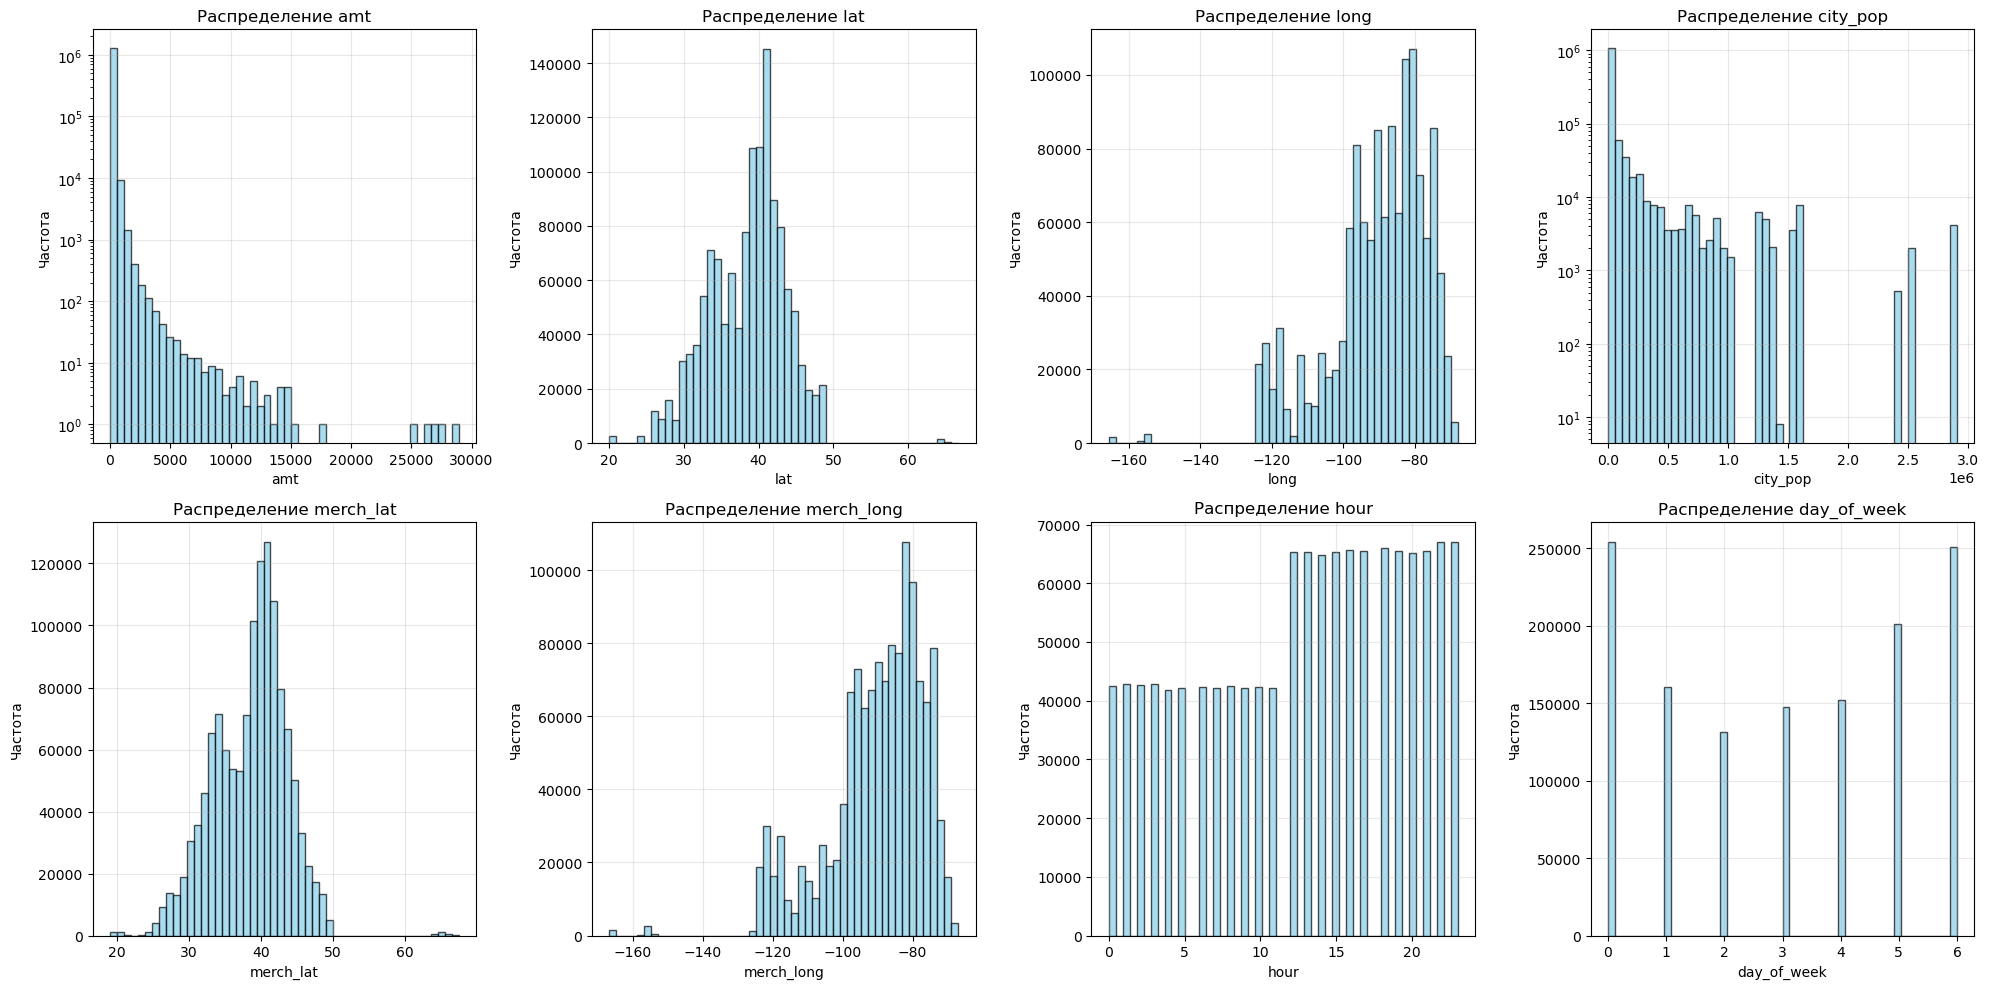

In [65]:
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'hour', 'day_of_week']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
    axes[i].grid(True, alpha=0.3)

    if col in ['amt', 'city_pop']:
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

Из построеннах графиков можно сделать предварительные выводы о структуре данных и возможных закономерностях, которые требуют дальнейшей детальной проверки:
 - большинство транзакций совершается на небольшие суммы, тогда как крупные платежи встречаются редко.
 - широта и долгота клиента и продавца распределены примерно нормально, указывая на концентрацию операций в пределах одного региона
- большинство транзакций происходит в небольших населённых пунктах. 
 - Большинство транзакций совершаются днем и в выходные дни

Также для численных признаков построим боксплоты:

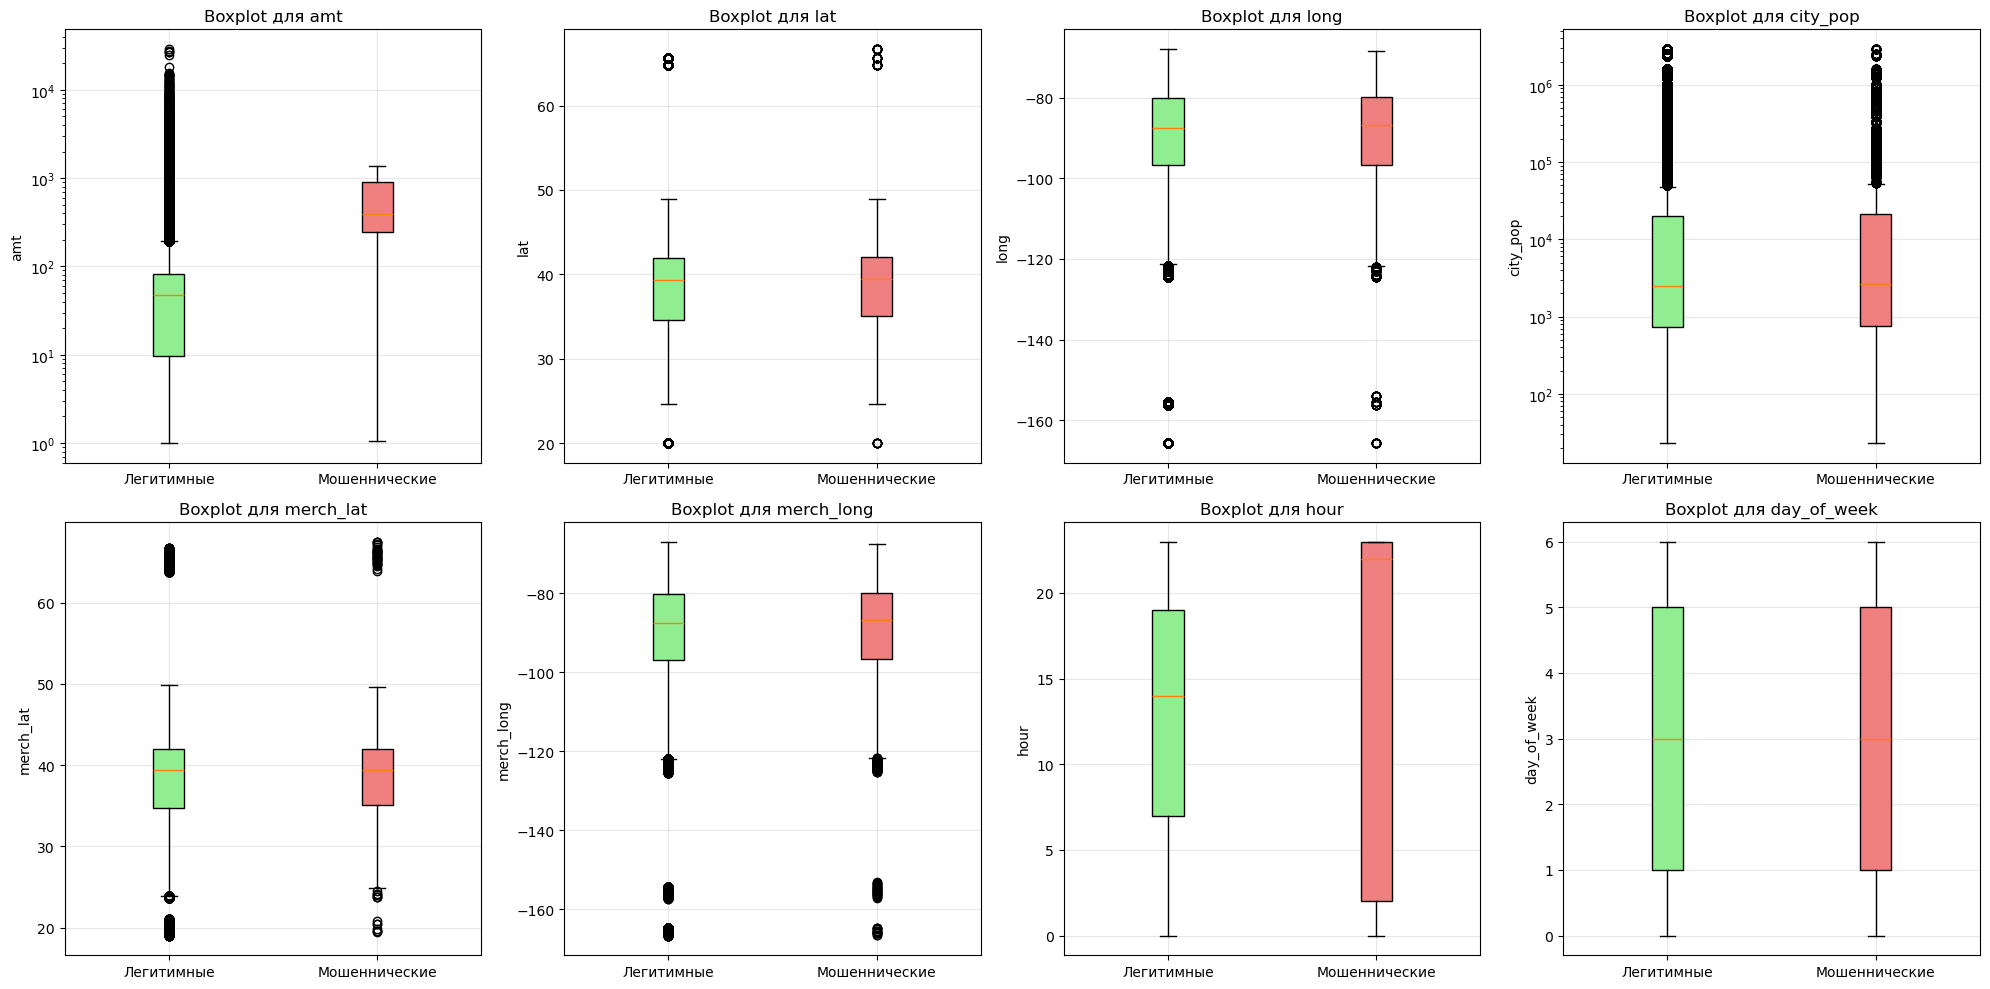

In [64]:
# Boxplot для числовых признаков
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    box_data = [df[df['is_fraud']==0][col].values, df[df['is_fraud']==1][col].values]
    bp = axes[i].boxplot(box_data, labels=['Легитимные', 'Мошеннические'], patch_artist=True)
    
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    
    if col in ['amt', 'city_pop']:
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()


Отсюда также можно предварительно выявить различия между группами:

- Мошеннические операции чаще совершаются на более крупные суммы и имеют больший разброс по времени — они чаще происходят ночью. 
- Географические признаки и население города (city_pop) не показывают существенных различий между классами

Теперь построим распределения для категориальных признаков. Так как в state и job много уникальных значений (51 и 194), для них выведем только топ-15 категорий:

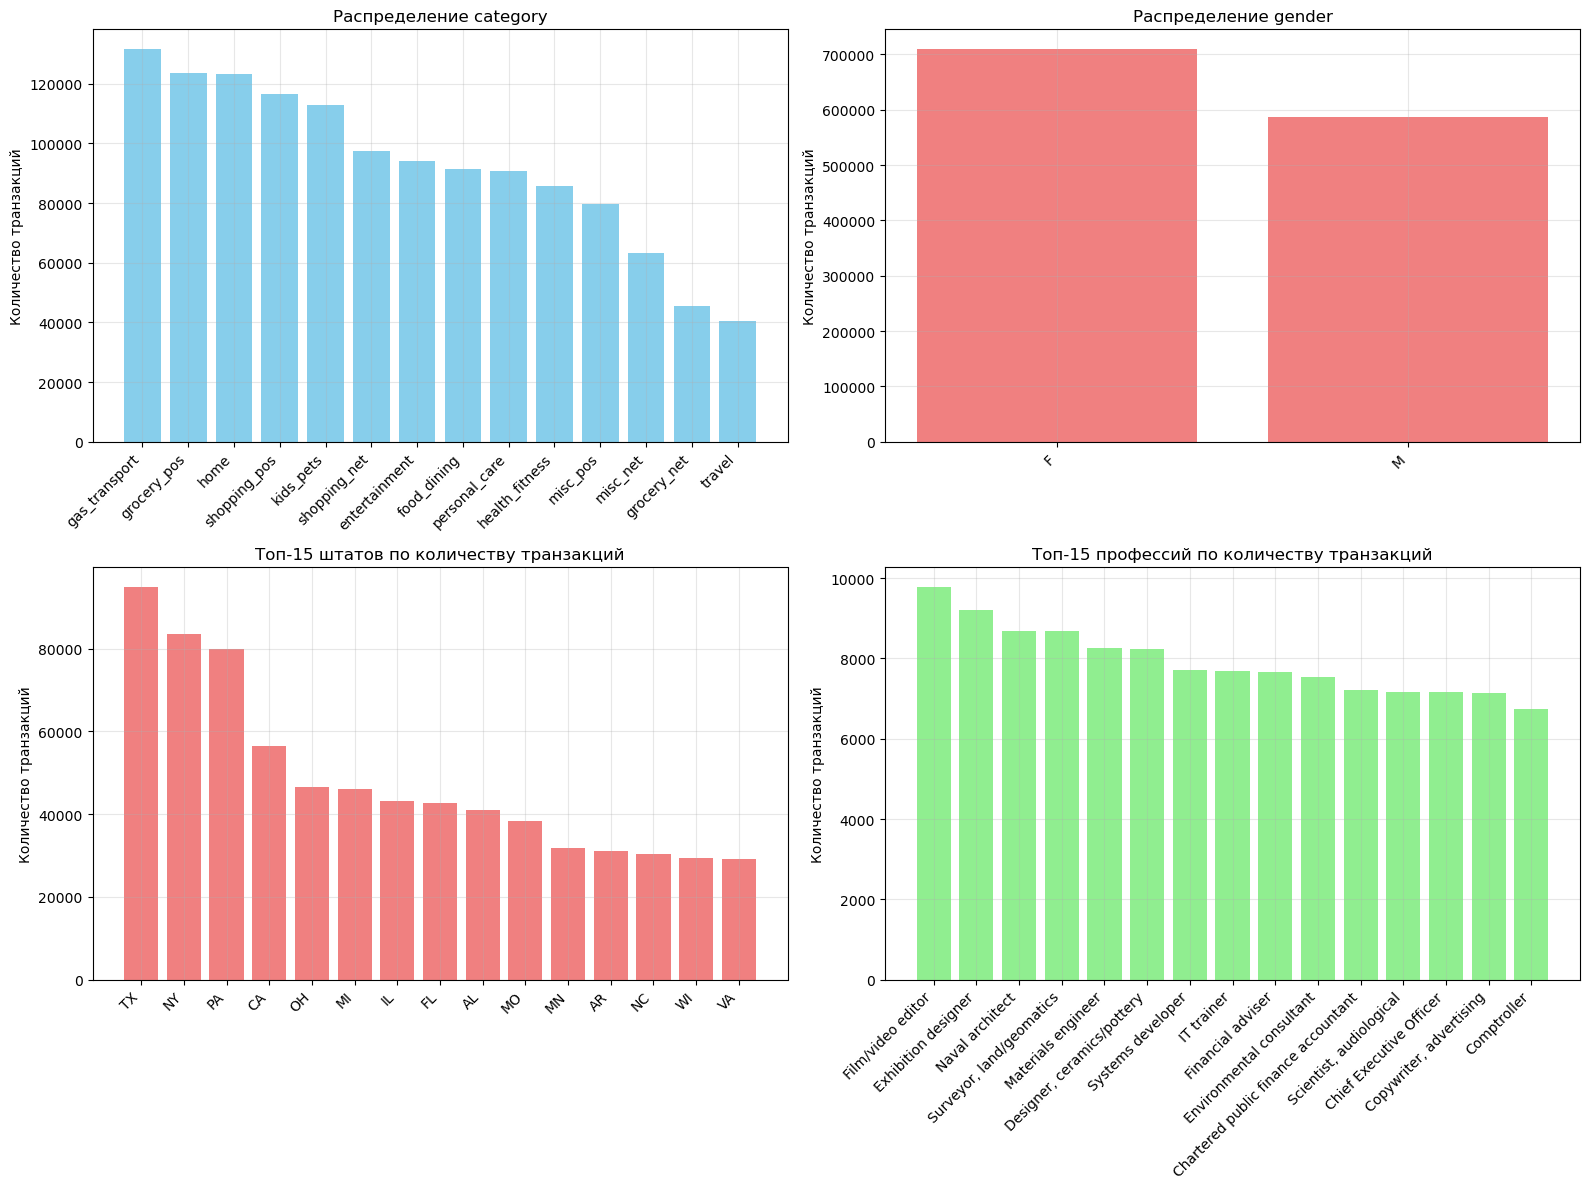

In [66]:
categorical_cols = ['category', 'gender', 'state', 'job']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col == 'state':
        top_states = df[col].value_counts().head(15)
        axes[i].bar(range(len(top_states)), top_states.values, color='lightcoral')
        axes[i].set_xticks(range(len(top_states)))
        axes[i].set_xticklabels(top_states.index, rotation=45, ha='right')
        axes[i].set_title(f'Топ-15 штатов по количеству транзакций')
    elif col == 'job':
        top_jobs = df[col].value_counts().head(15)
        axes[i].bar(range(len(top_jobs)), top_jobs.values, color='lightgreen')
        axes[i].set_xticks(range(len(top_jobs)))
        axes[i].set_xticklabels(top_jobs.index, rotation=45, ha='right')
        axes[i].set_title(f'Топ-15 профессий по количеству транзакций')
    else:
        value_counts = df[col].value_counts()
        axes[i].bar(range(len(value_counts)), value_counts.values, 
                    color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][i])
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[i].set_title(f'Распределение {col}')
    
    axes[i].set_ylabel('Количество транзакций')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Сделаем предварительные выводы:

- в категориях gas_transport, grocery_pos и home совершается большее число транзакций
- Женщины совершают больше транзакций. Надо проверить, различается ли доля таргета по полу. 
- Наибольшая активность наблюдается в крупных штатах, где высокие объёмы могут маскировать мошеннические операции
- Распределение по профессиям также неравномерно

Теперь рассмотрим наиболее интересные зависимости более детально:

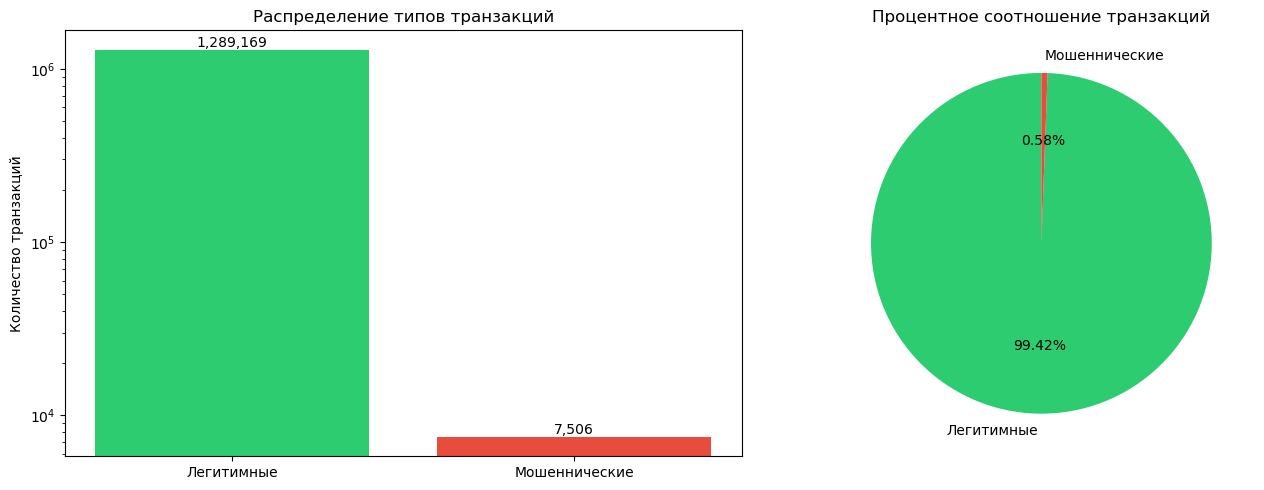

In [9]:
# График 1: Распределение целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Легитимные', 'Мошеннические'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Количество транзакций')
axes[0].set_title('Распределение типов транзакций')
axes[0].set_yscale('log')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts.values, labels=['Легитимные', 'Мошеннические'], 
           autopct='%1.2f%%', colors=colors, startangle=90)
axes[1].set_title('Процентное соотношение транзакций')

plt.tight_layout()
plt.show()

Видим сильный дисбаланс классов, мошеннических транзакций всего ~0.6% от общего числа

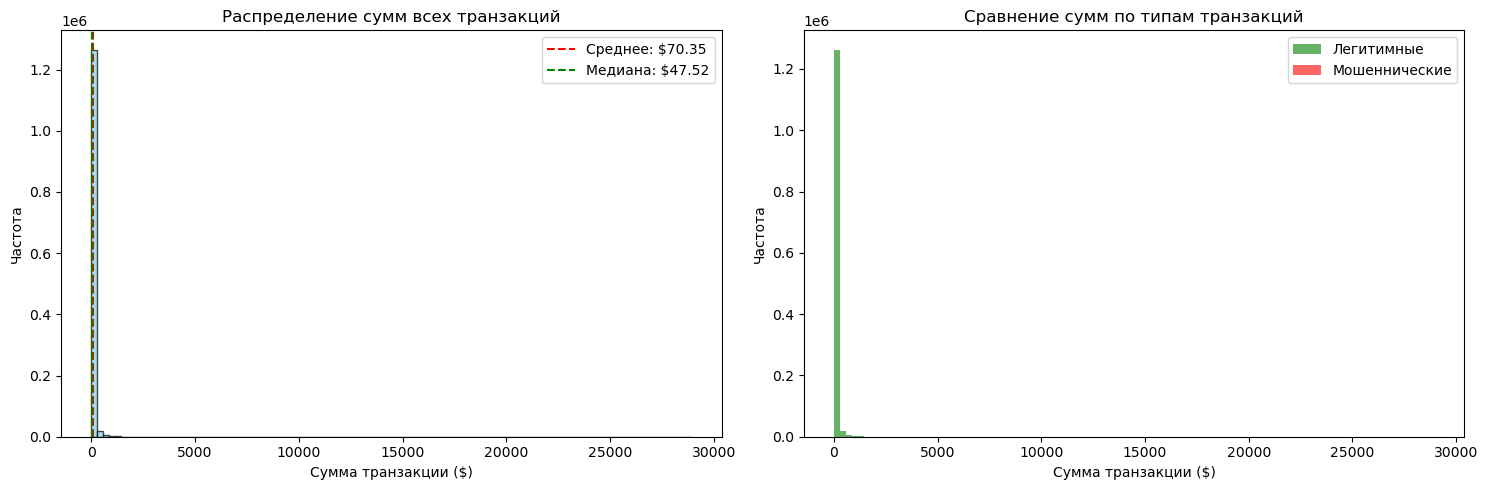


Статистика сумм транзакций:
Легитимные - Среднее: $67.67, Медиана: $47.28
Мошеннические - Среднее: $531.32, Медиана: $396.50


In [10]:
# График 2: Распределение суммы транзакций (amt)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['amt'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Сумма транзакции ($)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение сумм всех транзакций')
axes[0].axvline(df['amt'].mean(), color='red', linestyle='--', label=f'Среднее: ${df["amt"].mean():.2f}')
axes[0].axvline(df['amt'].median(), color='green', linestyle='--', label=f'Медиана: ${df["amt"].median():.2f}')
axes[0].legend()

axes[1].hist(df[df['is_fraud']==0]['amt'], bins=100, alpha=0.6, 
            label='Легитимные', color='green')
axes[1].hist(df[df['is_fraud']==1]['amt'], bins=100, alpha=0.6, 
            label='Мошеннические', color='red')
axes[1].set_xlabel('Сумма транзакции ($)')
axes[1].set_ylabel('Частота')
axes[1].set_title('Сравнение сумм по типам транзакций')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nСтатистика сумм транзакций:")
print(f"Легитимные - Среднее: ${df[df['is_fraud']==0]['amt'].mean():.2f}, "
      f"Медиана: ${df[df['is_fraud']==0]['amt'].median():.2f}")
print(f"Мошеннические - Среднее: ${df[df['is_fraud']==1]['amt'].mean():.2f}, "
      f"Медиана: ${df[df['is_fraud']==1]['amt'].median():.2f}")

Распределение сумм отклоняется в правую сторону и присутствуют крупные транзакции (выбросы). Также медиана заметно ниже среднего, что подтверждает асимметрию. 

Для графика сравнения сумм по типам транзакций, сделаем преобразование в логарифмическую шкалу, чтобы рассмотреть разницу детальнее:

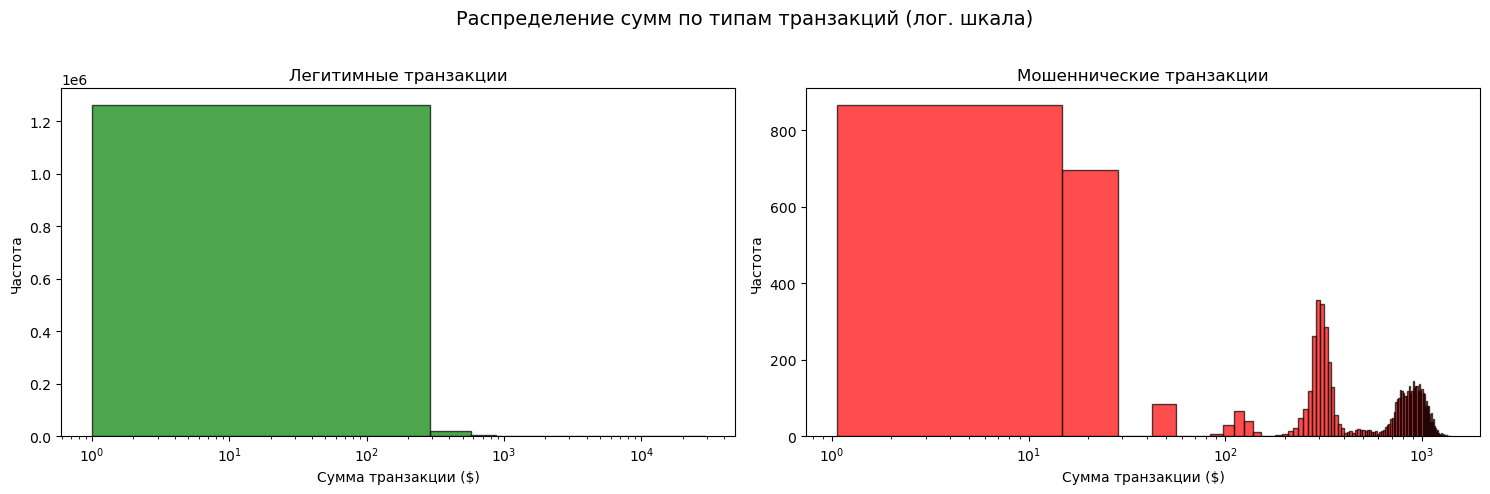

In [11]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df[df['is_fraud'] == 0]['amt'], bins=100, color='green', alpha=0.7, edgecolor='black')
axes[0].set_xscale('log')
axes[0].set_title('Легитимные транзакции')
axes[0].set_xlabel('Сумма транзакции ($)')
axes[0].set_ylabel('Частота')

axes[1].hist(df[df['is_fraud'] == 1]['amt'], bins=100, color='red', alpha=0.7, edgecolor='black')
axes[1].set_xscale('log')
axes[1].set_title('Мошеннические транзакции')
axes[1].set_xlabel('Сумма транзакции ($)')
axes[1].set_ylabel('Частота')

plt.suptitle('Распределение сумм по типам транзакций (лог. шкала)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


На графике слева видим очень сильную концентрацию мелких сумм, значит обычные пользователи совершают множество мелких покупок, и изредка совершают крупные переводы. 

Распределение мошеннических транзакций, наоборот растянутое, имеются несколько пиков, что говорит о том что здесь предпочтение отдают более крупным суммам и повторение схожих шаблонов

Также можем построить боксплоты для обоих типов транзакций:

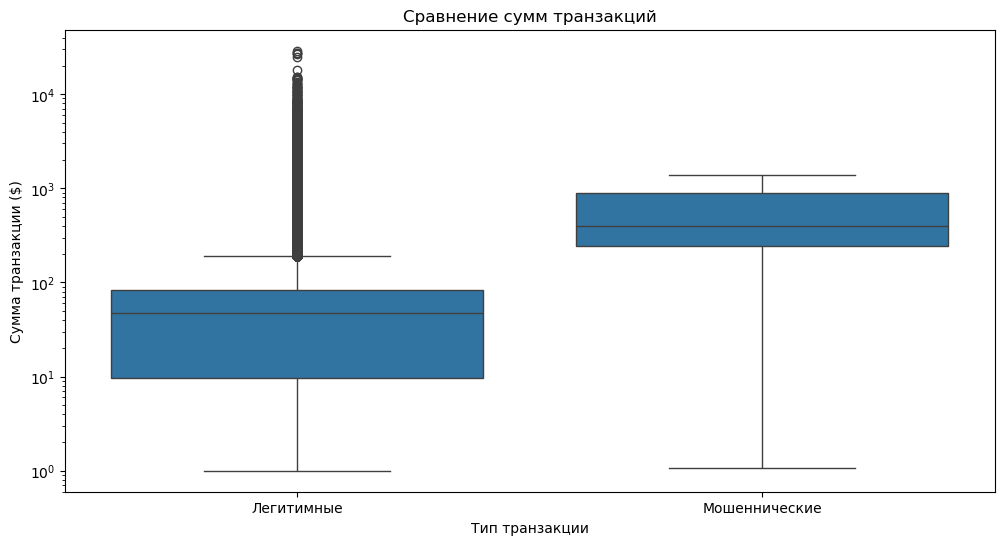

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='is_fraud', y='amt')
plt.yscale('log')
plt.xlabel('Тип транзакции')
plt.ylabel('Сумма транзакции ($)')
plt.title('Сравнение сумм транзакций')
plt.xticks([0, 1], ['Легитимные', 'Мошеннические'])
plt.savefig('03_amount_boxplot_log.png', dpi=300, bbox_inches='tight')
plt.show()


Отсюда делаются аналогичные выводы: редкие и крупные переводы среди обычных пользователей, и однотипные, в рамках определенного диапазона - среди мошенников

Далее посмотрим на динамику транзакций по времени. Для этого строятся график общей активности транзакций по часам и сравнительный график для двух типов:

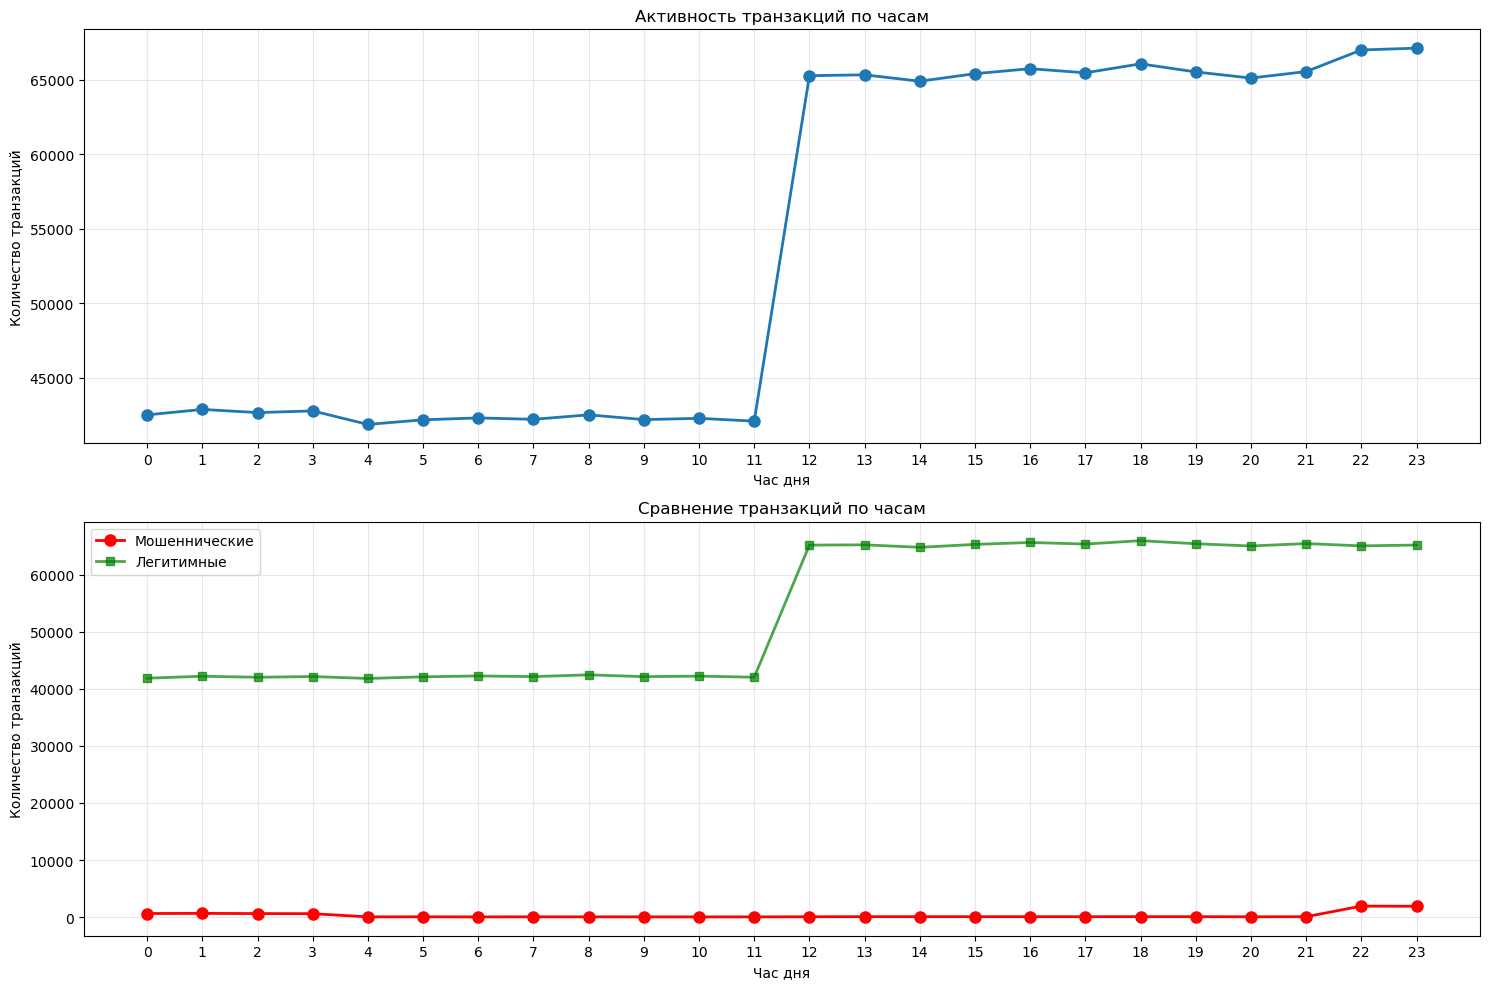

In [ ]:
# График 4: Транзакции по часам
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

hour_counts = df.groupby('hour')['is_fraud'].count()
axes[0].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Количество транзакций')
axes[0].set_title('Активность транзакций по часам')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

fraud_by_hour = df[df['is_fraud']==1].groupby('hour').size()
legit_by_hour = df[df['is_fraud']==0].groupby('hour').size()

axes[1].plot(fraud_by_hour.index, fraud_by_hour.values, marker='o', 
            label='Мошеннические', color='red', linewidth=2, markersize=8)
axes[1].plot(legit_by_hour.index, legit_by_hour.values, marker='s', 
            label='Легитимные', color='green', linewidth=2, markersize=6, alpha=0.7)
axes[1].set_xlabel('Час дня')
axes[1].set_ylabel('Количество транзакций')
axes[1].set_title('Сравнение транзакций по часам')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

Из верхнего графика, следует, что пользователи начинают активно совершать покупки и переводы после полудня (в рабочее и вечернее время). 

На нижнем сравнительном графике - легитимные транзакции полностью повторяют тренд общего графика, а мошеннических транзакций на порядок ниже и уже нет повторения шаблона. Но у них видим рост активности начиная ближе к ночи (22 часа) и до самого утра (3-4 часа). Это указывает на их попытки совершать транзакции в менее активные часы мониторинга.

Продолжаем исследовать динамику по времени и переходим к распределению по дням недели

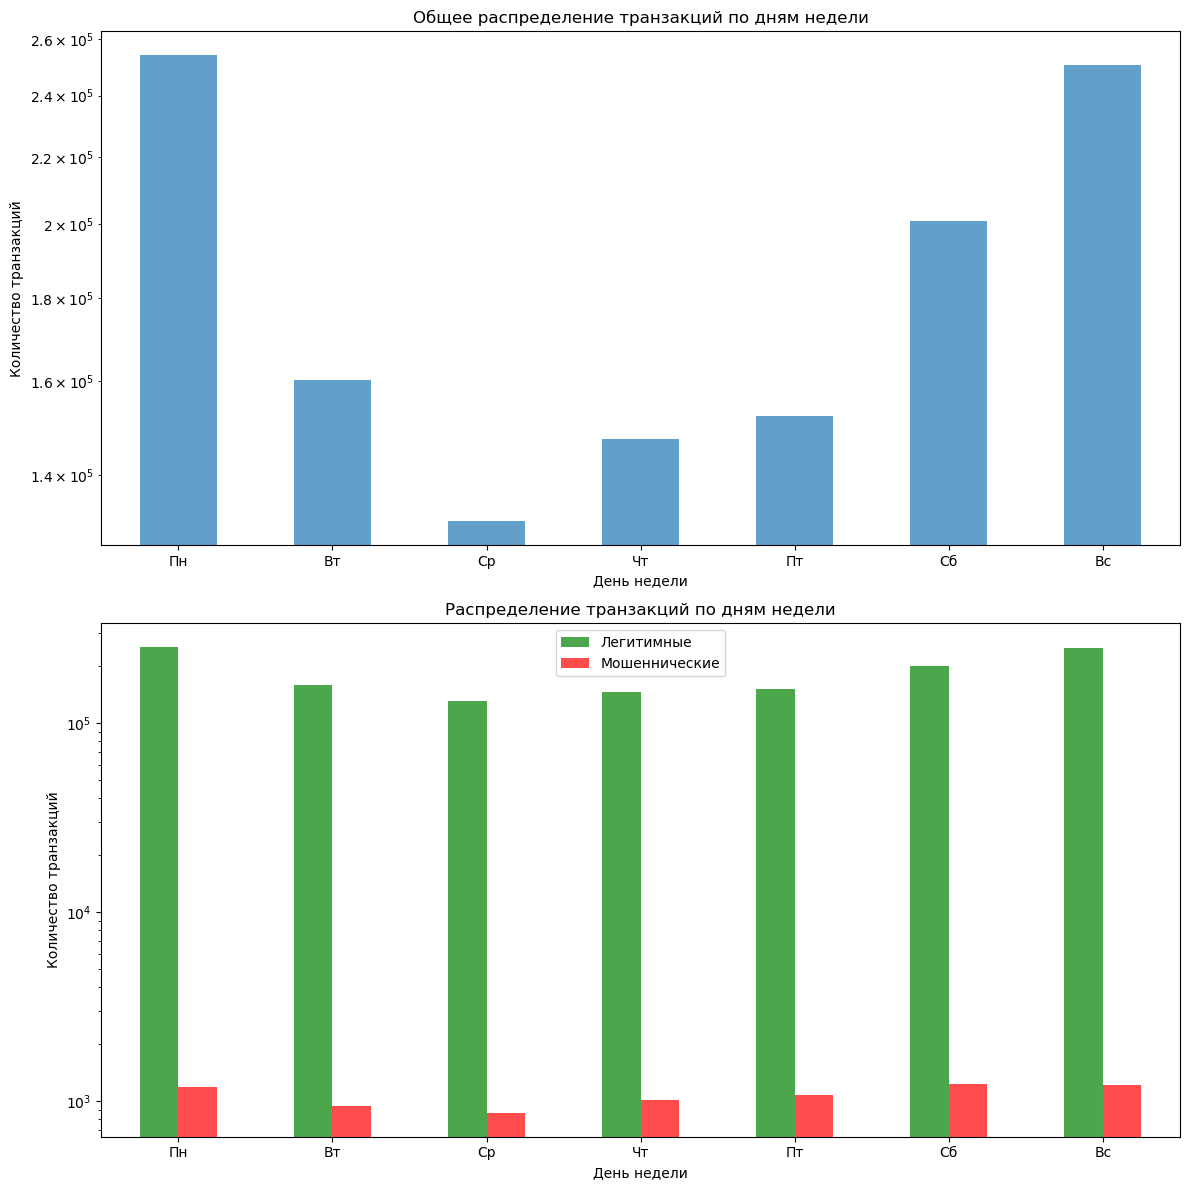

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

total_by_day = df.groupby('day_of_week').size()
total_by_day.plot(kind='bar', ax=axs[0], alpha=0.7)
axs[0].set_xlabel('День недели')
axs[0].set_ylabel('Количество транзакций')
axs[0].set_title('Общее распределение транзакций по дням недели')
axs[0].set_xticklabels(day_names, rotation=0)
axs[0].set_yscale('log')

fraud_by_day = df.groupby(['day_of_week', 'is_fraud']).size().unstack()
fraud_by_day.plot(kind='bar', ax=axs[1], color=['green', 'red'], alpha=0.7)
axs[1].set_xlabel('День недели')
axs[1].set_ylabel('Количество транзакций')
axs[1].set_title('Распределение транзакций по дням недели')
axs[1].set_xticklabels(day_names, rotation=0)
axs[1].legend(['Легитимные', 'Мошеннические'])
axs[1].set_yscale('log')
plt.tight_layout()
plt.show()

Из графика общего распределения количества транзакций, видно, что они увеличиваются к концу рабочей недели (пятница) и растут вплоть до понедельника, дальше идет снижение.

Из нижнего, сравнительного графика видим, что  обычные пользователи, также как это было на примере с разрезом по часам, повторяют шаблон общего распределения.

В мошеннеческих операциях нет таких резких скачков в середине недели, но в выходные (сб-вс) и до понедельника их активность повышается. Видимо таким образом они пытаются раствориться среди большого потока легитимных пользователей.

На этом заканчиваем с временными графиками и переходим к разрезу мошеннических транзакций по категориям. Построим графики Топ-10 категорий по проценту и количеству таких транзакций:

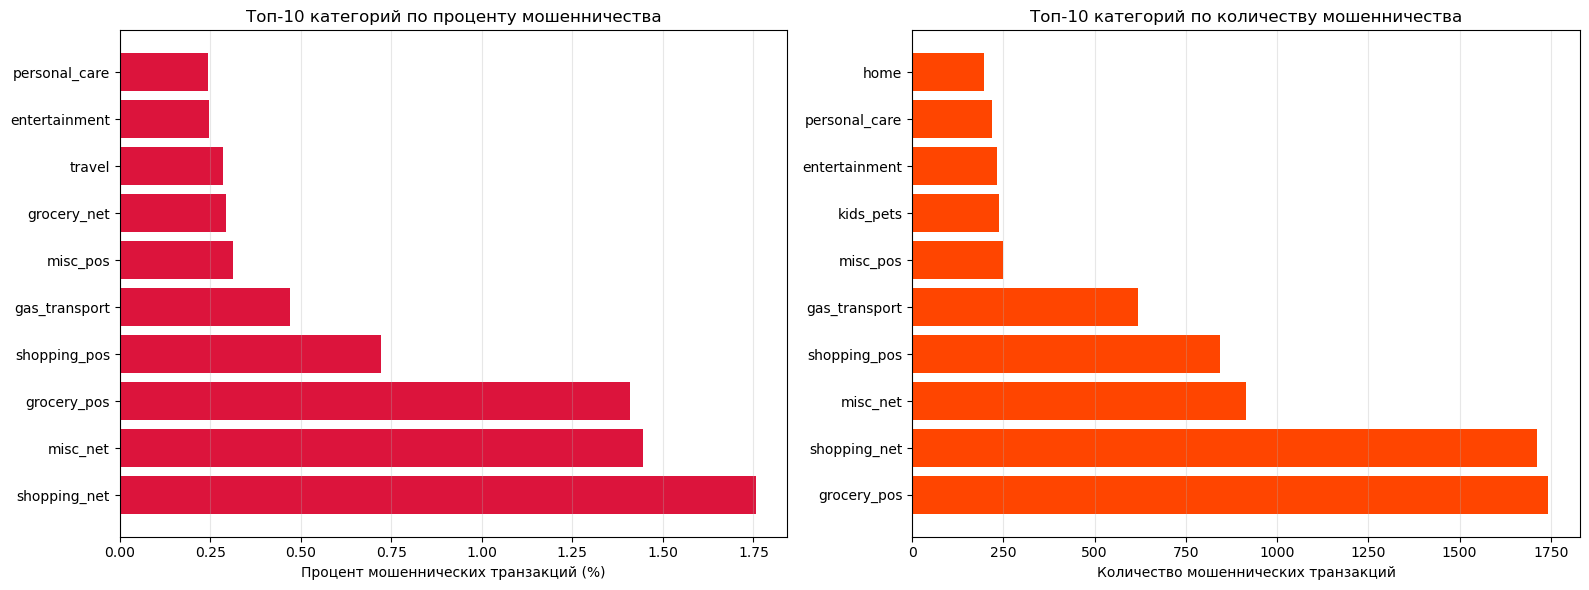


Категории с наибольшим процентом мошенничества:
                sum   count  fraud_rate
category                               
shopping_net   1713   97543    1.756149
misc_net        915   63287    1.445795
grocery_pos    1743  123638    1.409761
shopping_pos    843  116672    0.722538
gas_transport   618  131659    0.469394
misc_pos        250   79655    0.313853
grocery_net     134   45452    0.294817
travel          116   40507    0.286370
entertainment   233   94014    0.247835
personal_care   220   90758    0.242403


In [15]:
# График 6: Топ категорий с мошенничеством
category_fraud = df.groupby('category')['is_fraud'].agg(['sum', 'count'])
category_fraud['fraud_rate'] = (category_fraud['sum'] / category_fraud['count'] * 100)
category_fraud = category_fraud.sort_values('fraud_rate', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_fraud_categories = category_fraud.head(10)
axes[0].barh(range(len(top_fraud_categories)), top_fraud_categories['fraud_rate'].values, 
            color='crimson')
axes[0].set_yticks(range(len(top_fraud_categories)))
axes[0].set_yticklabels(top_fraud_categories.index)
axes[0].set_xlabel('Процент мошеннических транзакций (%)')
axes[0].set_title('Топ-10 категорий по проценту мошенничества')
axes[0].grid(axis='x', alpha=0.3)

top_fraud_count = df[df['is_fraud']==1]['category'].value_counts().head(10)
axes[1].barh(range(len(top_fraud_count)), top_fraud_count.values, color='orangered')
axes[1].set_yticks(range(len(top_fraud_count)))
axes[1].set_yticklabels(top_fraud_count.index)
axes[1].set_xlabel('Количество мошеннических транзакций')
axes[1].set_title('Топ-10 категорий по количеству мошенничества')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nКатегории с наибольшим процентом мошенничества:")
print(category_fraud.head(10))

Левый график можно интерпретировать следующим образом: онлайн покупки (_net) больше подвержены мошенничеству, чем покупки в обычных магазинах (_pos). Например, в категории shopping_net почти 2 из 100 транзакций - мошеннические. 

Переходим к правому графику: несмотря на то, что shopping_net лидирует по проценту нелегетимных транзакций, количественнной мере, больше таких операций происходит в grocery_pos. Это можно объяснить тем, что в супермаркетах (_pos) совершается очень много покупок, поэтому даже небольшой процент дает большое количество инциндентов. 

Также, здесь misc_net и shopping_net также стоят в топе, подтверждая тенденцию, что онлайн транзакции несут повышенные риски.

Следующим шагом, проверим зависит ли кол-во тех или иных транзакций от пола:

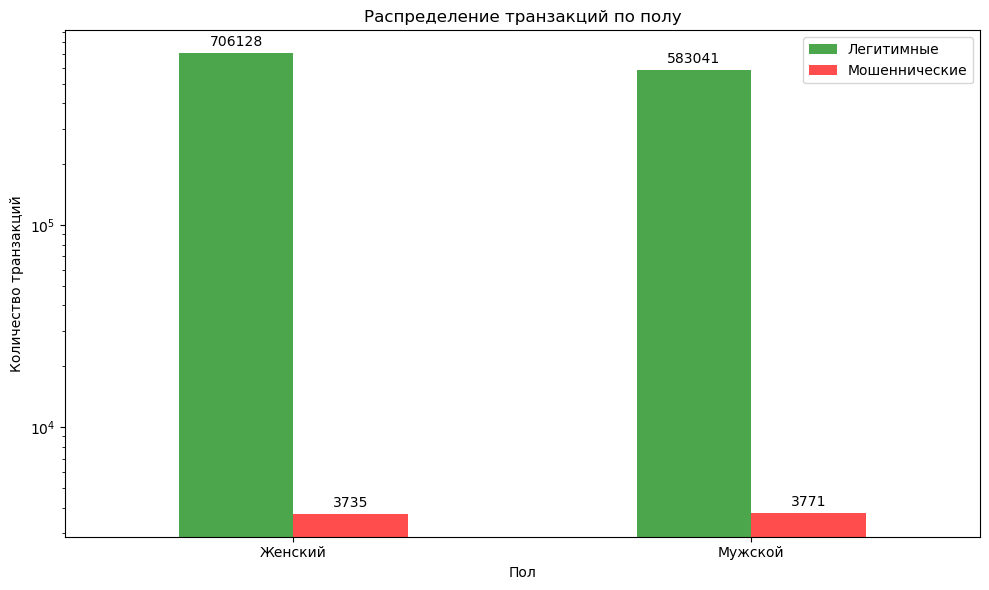

In [16]:
gender_fraud = df.groupby(['gender', 'is_fraud']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
gender_fraud.plot(kind='bar', ax=ax, color=['green', 'red'], alpha=0.7)
ax.set_xlabel('Пол')
ax.set_ylabel('Количество транзакций')
ax.set_title('Распределение транзакций по полу')
ax.set_xticklabels(['Женский', 'Мужской'], rotation=0)
ax.legend(['Легитимные', 'Мошеннические'])
ax.set_yscale('log')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3, fontsize=10)


plt.tight_layout()
plt.show()

Женщины совершают чуть больше легитимных транзакций чем мужчины, а мошенников в разрезе по полу - одинаковое количество. 


Далее изучим географическое распределение типов транзакций. Первым делом, построим графики, показывающие топ-15 штатов по проценту мошеннических транзакций и по их общему количеству.

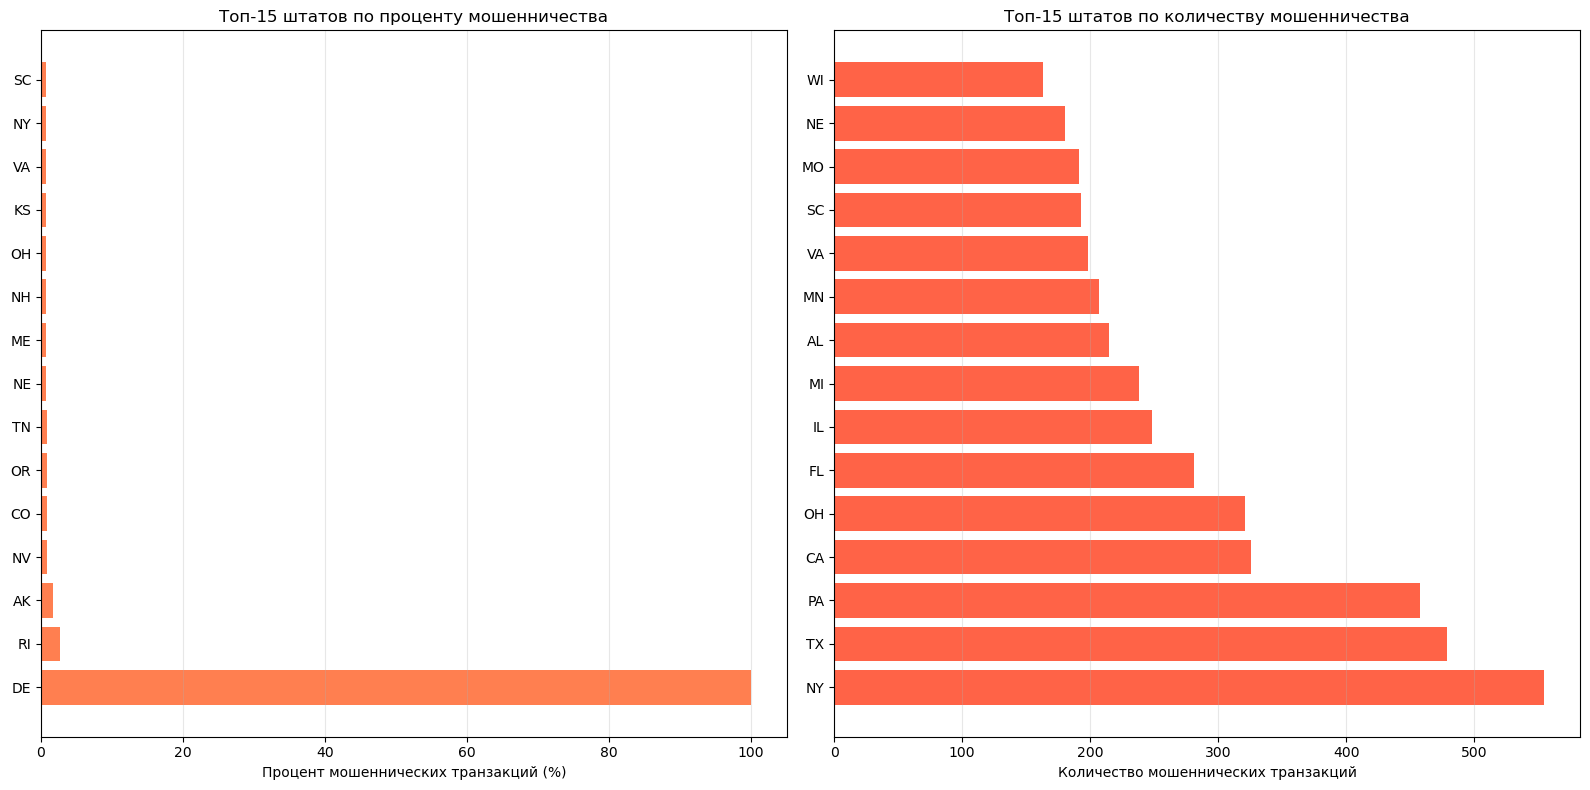

In [17]:
# График 7: Топ штатов по мошенничеству
state_fraud = df.groupby('state')['is_fraud'].agg(['sum', 'count'])
state_fraud['fraud_rate'] = (state_fraud['sum'] / state_fraud['count'] * 100)
state_fraud = state_fraud.sort_values('fraud_rate', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_states = state_fraud.head(15)
axes[0].barh(range(len(top_states)), top_states['fraud_rate'].values, color='coral')
axes[0].set_yticks(range(len(top_states)))
axes[0].set_yticklabels(top_states.index)
axes[0].set_xlabel('Процент мошеннических транзакций (%)')
axes[0].set_title('Топ-15 штатов по проценту мошенничества')
axes[0].grid(axis='x', alpha=0.3)

top_states_count = state_fraud.sort_values('sum', ascending=False).head(15)
axes[1].barh(range(len(top_states_count)), top_states_count['sum'].values, color='tomato')
axes[1].set_yticks(range(len(top_states_count)))
axes[1].set_yticklabels(top_states_count.index)
axes[1].set_xlabel('Количество мошеннических транзакций')
axes[1].set_title('Топ-15 штатов по количеству мошенничества')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Штат Делавэр (DE) выделяется аномально высоким значением, близким к 100%. Это, скорее всего, связано с малым количеством транзакций в выборке или ошибками сбора данных.

По абсолютному числу мошеннических трнзакций выделяются Нью-Йорк, Техас, Пенсильвания, Калифорния и Огайо. Это можно объяснить большим населением и соответствующим объемом всех транзакций в этих городах

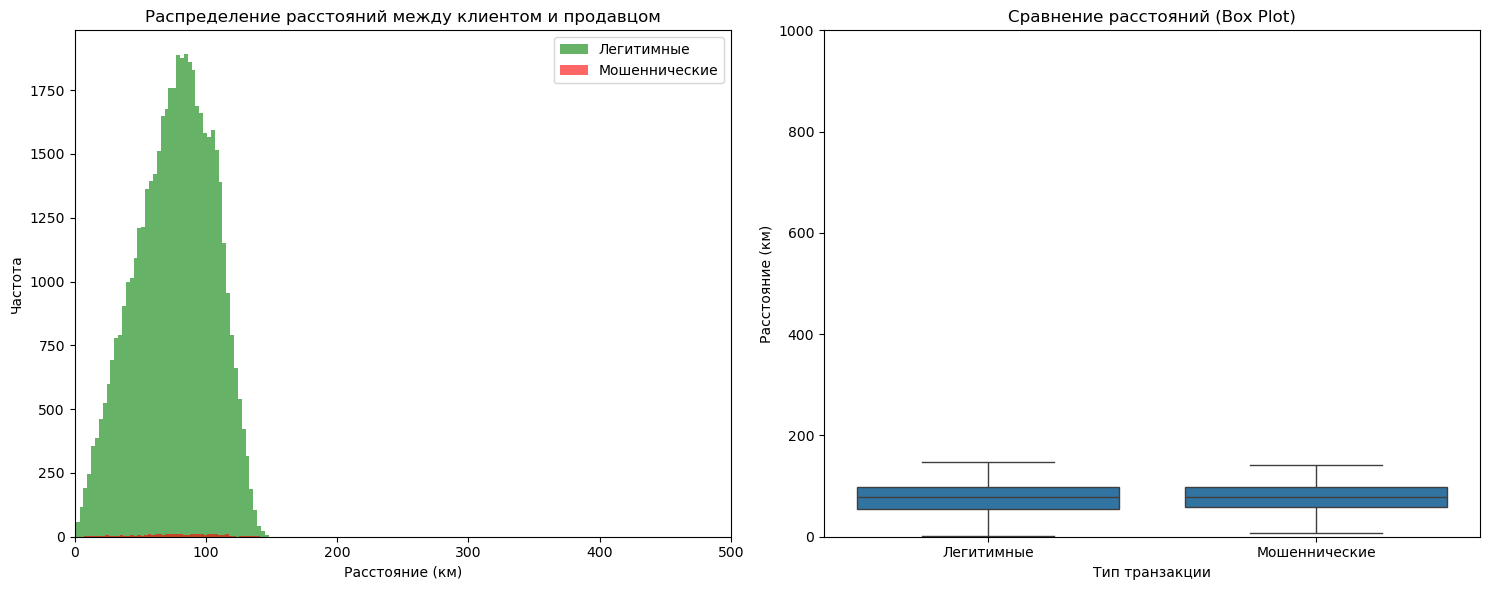


Средние расстояния:
Легитимные: 76.21 км
Мошеннические: 76.77 км


In [18]:
# Вычисление расстояния (упрощенная формула)
def haversine_distance(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, asin, sqrt
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

# Вычисляем расстояние для небольшой выборки
sample_df = df.sample(n=min(50000, len(df)), random_state=42)
sample_df['distance_km'] = sample_df.apply(
    lambda row: haversine_distance(row['lat'], row['long'], 
                                   row['merch_lat'], row['merch_long']), axis=1
)

# График 8: Распределение расстояний
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(sample_df[sample_df['is_fraud']==0]['distance_km'], bins=50, 
            alpha=0.6, label='Легитимные', color='green')
axes[0].hist(sample_df[sample_df['is_fraud']==1]['distance_km'], bins=50, 
            alpha=0.6, label='Мошеннические', color='red')
axes[0].set_xlabel('Расстояние (км)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение расстояний между клиентом и продавцом')
axes[0].legend()
axes[0].set_xlim(0, 500)

# Box plot
sns.boxplot(data=sample_df, x='is_fraud', y='distance_km', ax=axes[1])
axes[1].set_xlabel('Тип транзакции')
axes[1].set_ylabel('Расстояние (км)')
axes[1].set_title('Сравнение расстояний (Box Plot)')
axes[1].set_xticklabels(['Легитимные', 'Мошеннические'])
axes[1].set_ylim(0, 1000)

plt.tight_layout()
plt.savefig('09_distance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nСредние расстояния:")
print(f"Легитимные: {sample_df[sample_df['is_fraud']==0]['distance_km'].mean():.2f} км")
print(f"Мошеннические: {sample_df[sample_df['is_fraud']==1]['distance_km'].mean():.2f} км")

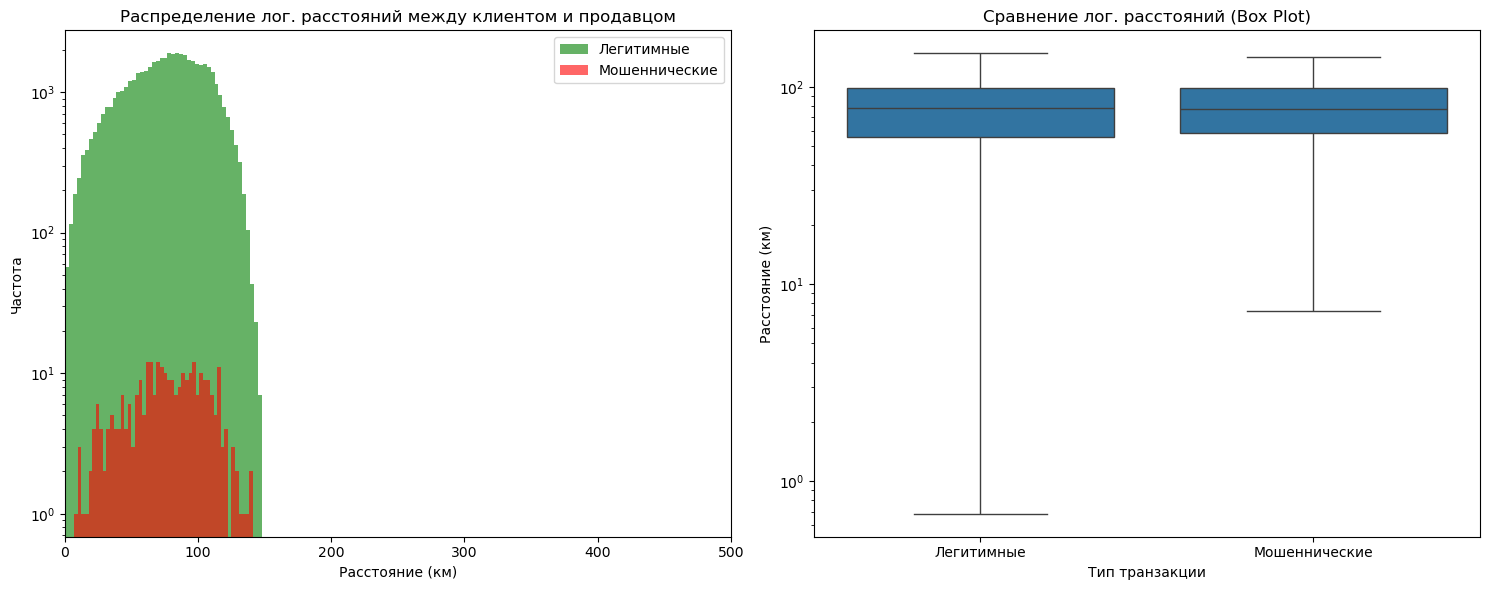

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(sample_df[sample_df['is_fraud']==0]['distance_km'], bins=50, 
            alpha=0.6, label='Легитимные', color='green')
axes[0].hist(sample_df[sample_df['is_fraud']==1]['distance_km'], bins=50, 
            alpha=0.6, label='Мошеннические', color='red')
axes[0].set_xlabel('Расстояние (км)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение лог. расстояний между клиентом и продавцом')
axes[0].legend()
axes[0].set_xlim(0, 500)
axes[0].set_yscale('log')

sns.boxplot(data=sample_df, x='is_fraud', y='distance_km', ax=axes[1])
axes[1].set_xlabel('Тип транзакции')
axes[1].set_ylabel('Расстояние (км)')
axes[1].set_title('Сравнение лог. расстояний (Box Plot)')
axes[1].set_xticklabels(['Легитимные', 'Мошеннические'])
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

Видно, что большинство транзакций, совершенных обычными пользователями, совершается на сравнительно небольшом расстоянии - до 100 км. 

Мошеннические транзакции, в целом следуют тому же распределению, однако их плотность немного выше на средних расстояниях, что может говорить о том, что таким образом они пытаются маскироваться под легитимные операции.

Боксплоты подверждают вышеописанные выводы (у мошеннических операций "усы" графика уже, следовательно, высокая концентрация на средних расстояниях)

Идем дальше, построим корреляционную матрицу:

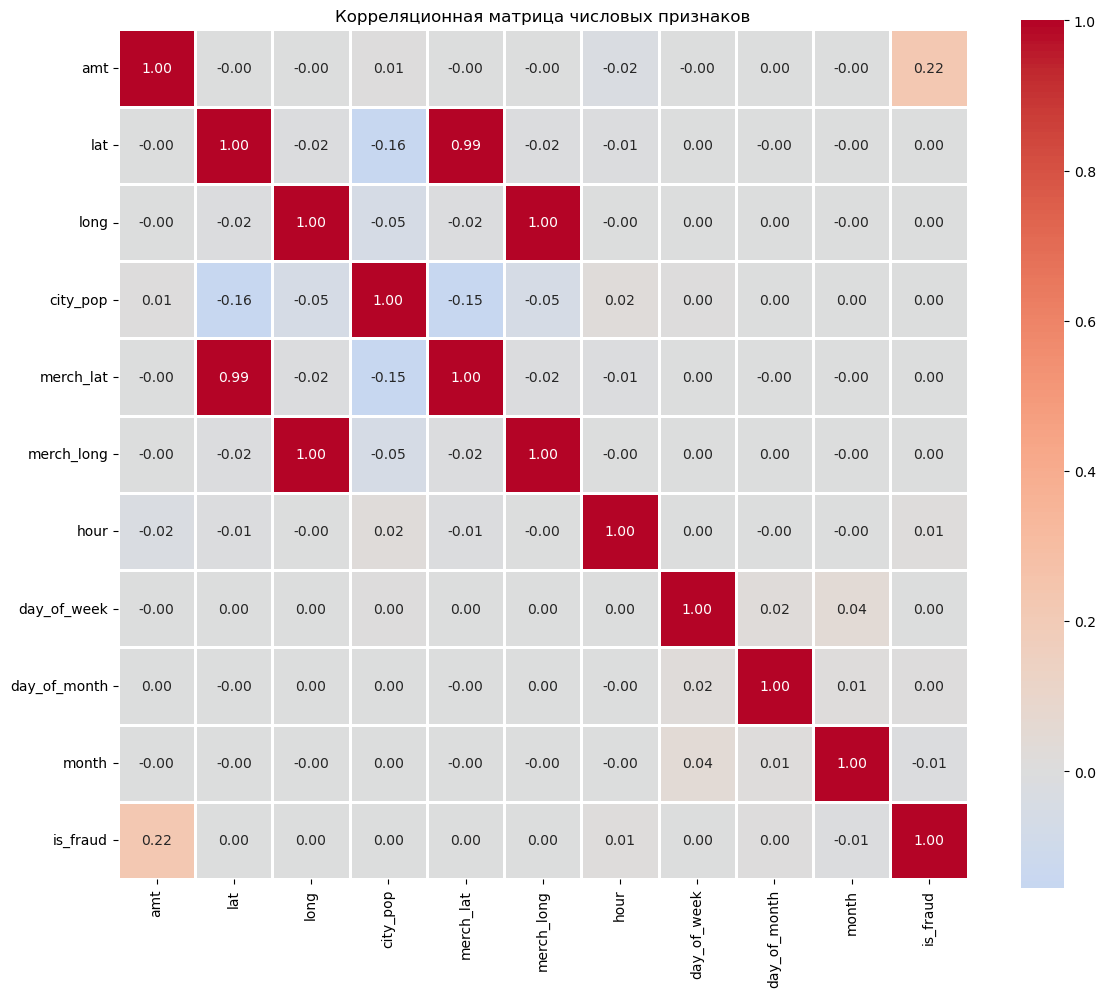


Корреляция признаков с целевой переменной:
is_fraud        1.000000
amt             0.219404
hour            0.013799
day_of_month    0.003848
city_pop        0.002136
lat             0.001894
merch_lat       0.001741
day_of_week     0.001739
merch_long      0.001721
long            0.001721
month          -0.012409
Name: is_fraud, dtype: float64


In [20]:
numeric_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'hour', 'day_of_week', 'day_of_month', 'month', 'is_fraud']

# График 9: Корреляционная матрица
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

print("\nКорреляция признаков с целевой переменной:")
print(correlation_matrix['is_fraud'].sort_values(ascending=False))

Почти все числовые признаки имеют слабую корреляцию между собой и с целевой переменной.

На этом заканчиваем исследовательский анализ и переходим к построению бейзлайна. 

## Препроцессинг

Первым делом выберем признаки и составим матрицу признаков и целевую переменную. 

Затем разобьем данные на обучающую и тестовую выборки в соотношении 80/20 с учетом временной природы данных. Используется time-based split: train формируется из более ранних транзакций (первые 80% по времени), а test — из более поздних (последние 20%). Такой подход позволяет оценить реальную способность модели к обобщению на будущих данных.

### Стратегия кодирования категориальных признаков:

На основе анализа категориальных признаков из EDA применяем разные стратегии:

1. Для переменных с низким кол-вом уникальных значений (category, gender) → **OneHot Encoding**
   - category: 14 значений
   - gender: 2 значения

2. Для переменных с высоким кол-вом уникальных значений (merchant, job) → **Frequency Encoding**
   - merchant: 693 значения
   - job: 494 значения

После кодирования high cardinality признаков создаем пайплайны: числовые признаки (включая frequency-encoded) масштабируются с помощью StandardScaler, а категориальные кодируются методом OneHotEncoder.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Frequency Encoder для категориальных признаков с высокой кардинальностью.
    Заменяет категории на их частоты, вычисленные на train данных.
    """
    def __init__(self):
        self.freq_maps_ = {}
    
    def fit(self, X, y=None):
        """Вычисляет частоты для каждого столбца на обучающих данных"""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        for col in X_df.columns:
            # Вычисляем нормализованные частоты
            freq_map = X_df[col].value_counts(normalize=True).to_dict()
            self.freq_maps_[col] = freq_map
        
        return self
    
    def transform(self, X):
        """Применяет частотное кодирование"""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        
        result = pd.DataFrame(index=X_df.index)
        
        for col in X_df.columns:
            freq_map = self.freq_maps_.get(col, {})
            result[f'{col}_freq'] = X_df[col].map(freq_map).fillna(0)
        
        return result.values
    def get_feature_names_out(self, input_features=None):   
        """Возвращает имена признаков после трансформации"""
        feature_names = getattr(self, "feature_names_out_", None)
        if feature_names is not None:
            return feature_names
        
        if input_features is not None:
            return [f"{col}_freq" for col in input_features]
        return []


In [ ]:
numerical_features = [
    'amt', 'lat', 'long', 'city_pop', 
    'merch_lat', 'merch_long', 'hour', 'day_of_week',
]

categorical_low = ['category', 'gender']  # 14 и 2 значения

categorical_high = ['merchant', 'job']  # 693 и 494 значения

In [ ]:
numerical_features = [
    'amt', 'lat', 'long', 'city_pop', 
    'merch_lat', 'merch_long', 'hour', 'day_of_week'
]

categorical_low = ['category', 'gender']  # OneHot
categorical_high = ['merchant', 'job']    # Frequency

df_sorted = df.sort_values('trans_date_trans_time').reset_index(drop=True)
split_index = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:split_index].copy()
test_df = df_sorted.iloc[split_index:].copy()

all_features = numerical_features + categorical_low + categorical_high

X_train = train_df[all_features]
y_train = train_df['is_fraud']
X_test = test_df[all_features]
y_test = test_df['is_fraud']

print("Размеры наборов:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\nВременные границы:")
print(f"Train: с {train_df['trans_date_trans_time'].min()} до {train_df['trans_date_trans_time'].max()}")
print(f"Test: с {test_df['trans_date_trans_time'].min()} до {test_df['trans_date_trans_time'].max()}")

print(f"\nДоля мошенничества (train): {y_train.mean():.4f}")
print(f"Доля мошенничества (test): {y_test.mean():.4f}")

Размеры наборов:
X_train: (1037340, 12), y_train: (1037340,)
X_test: (259335, 12), y_test: (259335,)

Временные границы:
Train: с 2019-01-01 00:00:18 до 2020-03-06 07:15:17
Test: с 2020-03-06 07:16:43 до 2020-06-21 12:13:37

Доля мошенничества (train): 0.0058
Доля мошенничества (test): 0.0059


In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numerical_features),
        
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_low),
        
        ('cat_high', FrequencyEncoder(), categorical_high)
    ],
    remainder='drop'
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("\n" + "="*60)
print("Результаты после препроцессинга:")
print("="*60)
print(f"X_train_proc: {X_train_proc.shape}")
print(f"X_test_proc: {X_test_proc.shape}")


Результаты после препроцессинга:
X_train_proc: (1037340, 26)
X_test_proc: (259335, 26)


In [46]:
print(f"   Мошеннических в train: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"   Мошеннических в test: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

   Мошеннических в train: 5968 (0.58%)
   Мошеннических в test: 1538 (0.59%)


## Обучение моделей (бейзлайн)

Сначала обучим логистическую регрессию:


===== Logistic Regression: Metrics =====
               precision    recall  f1-score   support

   Легитимные       1.00      0.88      0.93    257797
Мошеннические       0.04      0.76      0.07      1538

     accuracy                           0.88    259335
    macro avg       0.52      0.82      0.50    259335
 weighted avg       0.99      0.88      0.93    259335

Accuracy:   0.8777
Precision:  0.0358
Recall:     0.7568
F1-score:   0.0684
ROC-AUC:    0.9128


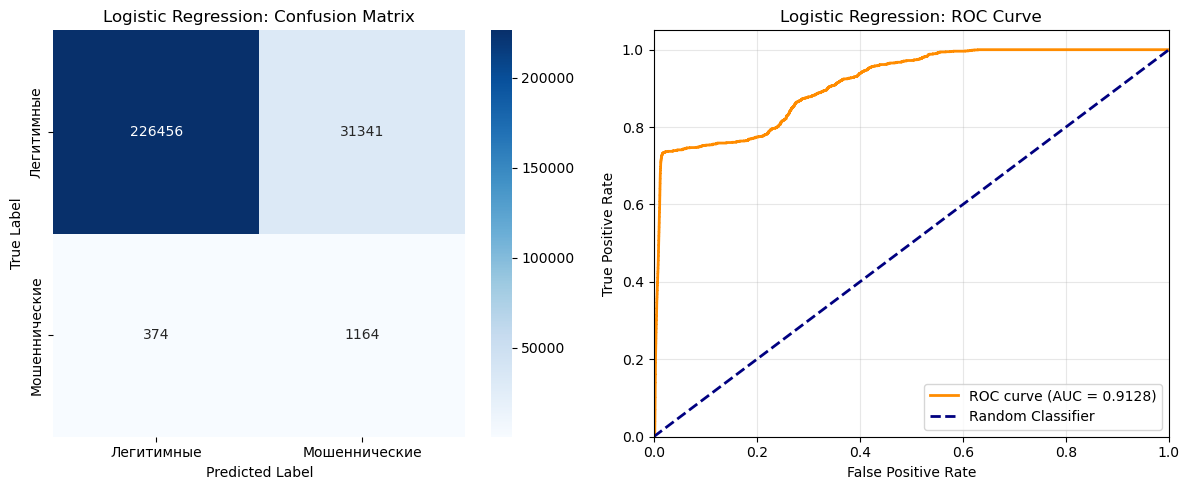

In [56]:
metrics_list = []

lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_proc, y_train)
y_pred_lr = lr_model.predict(X_test_proc)
y_pred_proba_lr = lr_model.predict_proba(X_test_proc)[:, 1]

metrics_list.append(
    evaluate_and_report(
        y_true=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred=y_pred_lr,
        y_proba=y_pred_proba_lr,
        model_name='Logistic Regression',
        target_names=['Легитимные', 'Мошеннические']
    )
)
plot_confusion_and_roc(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=y_pred_lr,
    y_proba=y_pred_proba_lr,
    model_name='Logistic Regression',
    class_labels=['Легитимные', 'Мошеннические']
)

Precision почти нулевой, модель отмечает много транзакций как мошеннические, совершая ложные срабатывания

Далее обучим ансамбль деревьев решений:


===== Random Forest: Metrics =====
               precision    recall  f1-score   support

   Легитимные       1.00      0.98      0.99    257797
Мошеннические       0.26      0.95      0.40      1538

     accuracy                           0.98    259335
    macro avg       0.63      0.96      0.70    259335
 weighted avg       1.00      0.98      0.99    259335

Accuracy:   0.9833
Precision:  0.2552
Recall:     0.9454
F1-score:   0.4019
ROC-AUC:    0.9932


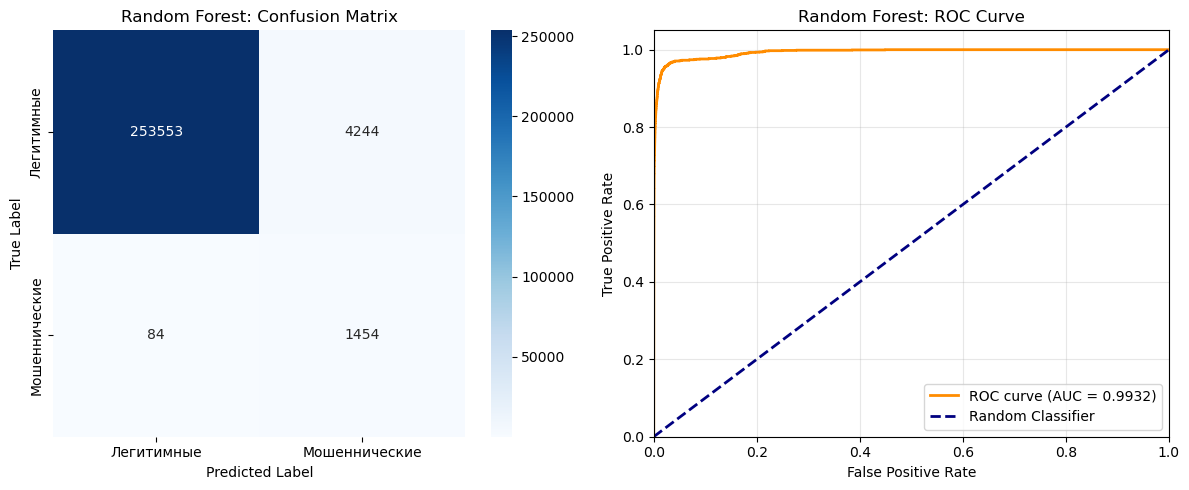

In [57]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42, 
    class_weight='balanced', 
    n_jobs=-1)

rf_model.fit(X_train_proc, y_train)
y_pred_rf = rf_model.predict(X_test_proc)
y_pred_proba_rf = rf_model.predict_proba(X_test_proc)[:, 1]

metrics_list.append(
    evaluate_and_report(
        y_true=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred=y_pred_rf,
        y_proba=y_pred_proba_rf,
        model_name='Random Forest',
        target_names=['Легитимные', 'Мошеннические']
    )
)
plot_confusion_and_roc(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=y_pred_rf,
    y_proba=y_pred_proba_rf,
    model_name='Random Forest',
    class_labels=['Легитимные', 'Мошеннические']
)

Получаем хороший reccall, но низкий precision. Данная модель также совершает большое кол-во ложных срабатываний, но в отличии от лог. регрессии выявляет 95 процентов мошеннеческих транзакций

Посморим на важность признаков этих двух моделей:

Количество признаков после препроцессинга: 26
Первые 10 признаков: ['num__amt', 'num__lat', 'num__long', 'num__city_pop', 'num__merch_lat', 'num__merch_long', 'num__hour', 'num__day_of_week', 'cat_low__category_entertainment', 'cat_low__category_food_dining']


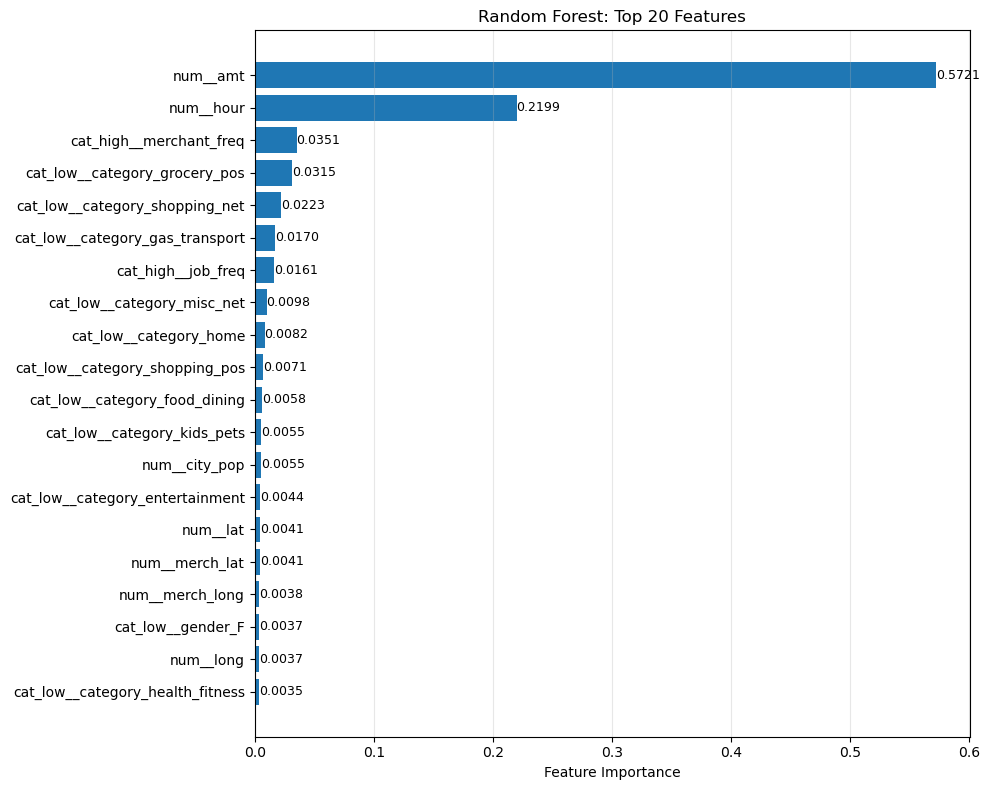

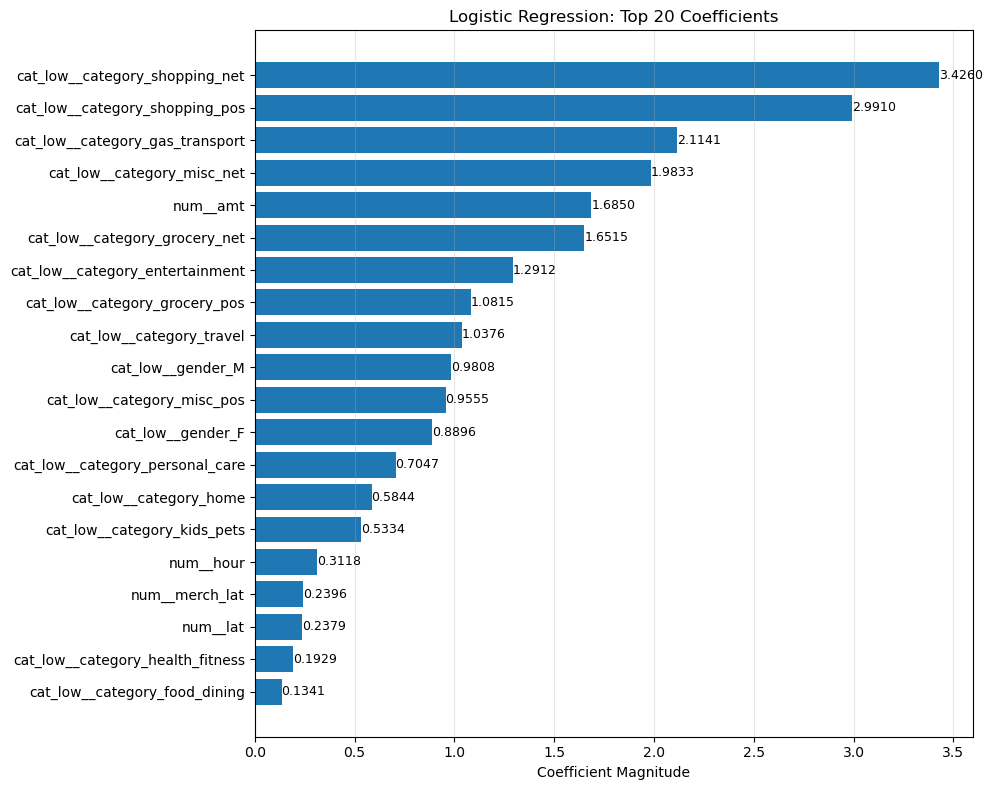

In [58]:
from eval_utils import plot_feature_importance

feature_names = preprocessor.get_feature_names_out()

print(f"Количество признаков после препроцессинга: {len(feature_names)}")
print(f"Первые 10 признаков: {feature_names[:10].tolist()}")

plot_feature_importance(
    rf_model,
    feature_names=feature_names,
    top_n=20,
    title='Random Forest: Top 20 Features'
)

plot_feature_importance(
    lr_model,
    feature_names=feature_names,
    top_n=20,
    title='Logistic Regression: Top 20 Coefficients'
)


Random Forest выделила сумму, время покупок, а также категории магазинов, в которых проходили транзакции как важные признаки. Лог. регрессия же, выделяет важными категориальные признаки, отвечающие за профессию пользователя

Далее обучим модели бустинга XGBoost и LightGBM


===== XGBClassifier: Metrics =====
               precision    recall  f1-score   support

   Легитимные       1.00      1.00      1.00    257797
Мошеннические       0.87      0.70      0.78      1538

     accuracy                           1.00    259335
    macro avg       0.94      0.85      0.89    259335
 weighted avg       1.00      1.00      1.00    259335

Accuracy:   0.9976
Precision:  0.8731
Recall:     0.7022
F1-score:   0.7784
ROC-AUC:    0.9899


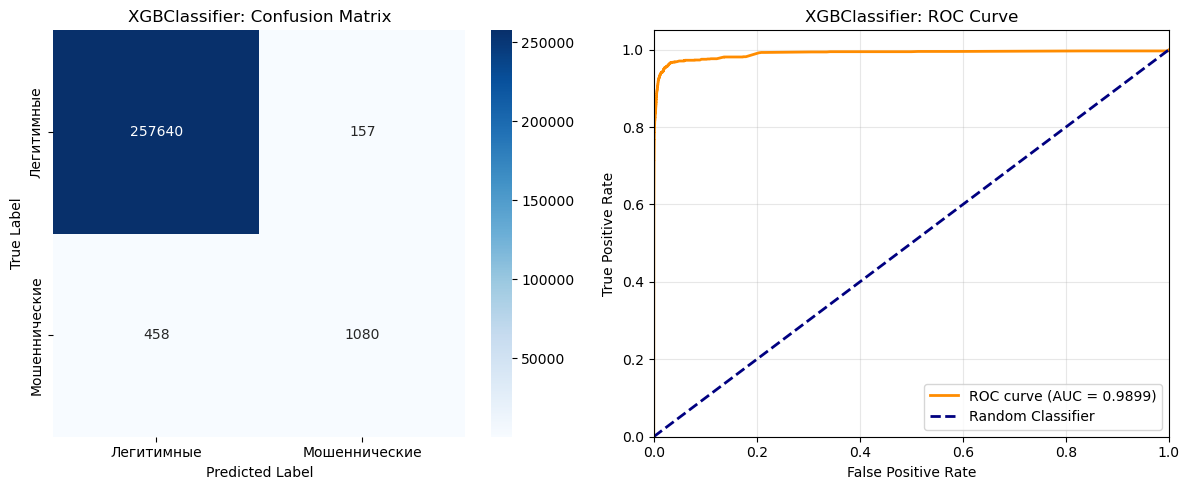

In [59]:
xgb = XGBClassifier(
    n_estimators=20, 
    max_depth=6, 
    learning_rate=0.1,
    random_state=42, 
    eval_metric='logloss')

xgb.fit(X_train_proc, y_train)
y_pred_xgb = xgb.predict(X_test_proc)
y_pred_proba_xgb = xgb.predict_proba(X_test_proc)[:, 1]

metrics_list.append(
    evaluate_and_report(
        y_true=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred=y_pred_xgb,
        y_proba=y_pred_proba_xgb,
        model_name='XGBClassifier',
        target_names=['Легитимные', 'Мошеннические']
    )
)
plot_confusion_and_roc(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=y_pred_xgb,
    y_proba=y_pred_proba_xgb,
    model_name='XGBClassifier',
    class_labels=['Легитимные', 'Мошеннические']
)

Тут уже получаем достаточно высокий Precision, но чуть худший Recall. Модель все еще часто ошибается и не охватывает достаточное кол-во мошеннеческих транзакций

[LightGBM] [Info] Number of positive: 5968, number of negative: 1031372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005753 -> initscore=-5.152233
[LightGBM] [Info] Start training from score -5.152233

===== LGBMClassifier: Metrics =====
               precision    recall  f1-score   support

   Легитимные       1.00      1.00      1.00    257797
Мошеннические       0.87      0.70      0.78      1538

     accuracy                           1.00    259335
    macro avg       0.93      0.85      0.89    259335
 weighted avg       1.00      1.00      1.00    259335

Accuracy:   0.9976
Precision:  0.8655
Recall:     0.7029
F1-score:   

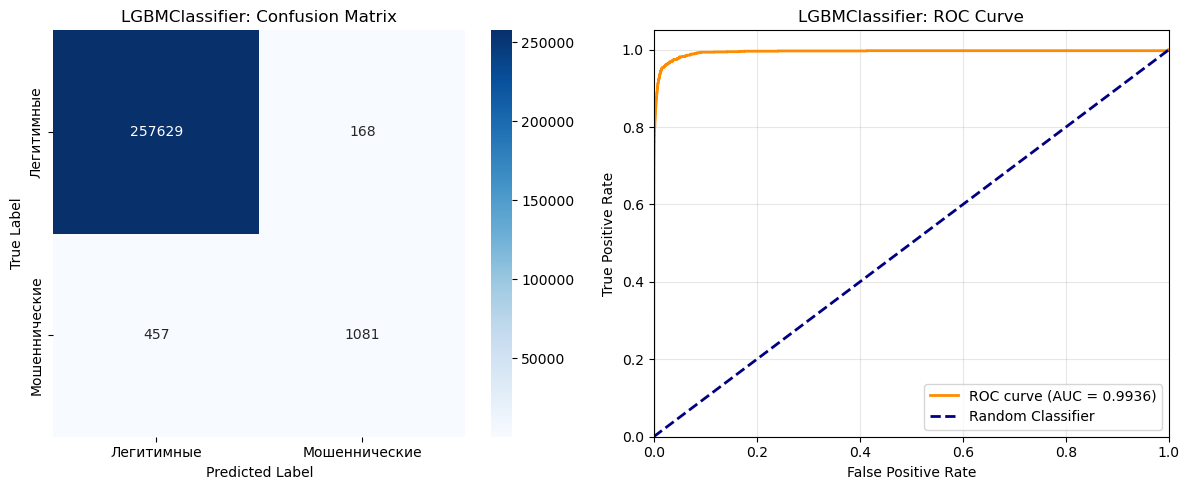

In [60]:
lgbm = LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05,
            n_jobs=-1,
            random_state=42
)

lgbm.fit(X_train_proc, y_train)
y_pred_lgbm = lgbm.predict(X_test_proc)
y_pred_proba_lgbm = lgbm.predict_proba(X_test_proc)[:, 1]

metrics_list.append(
    evaluate_and_report(
        y_true=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred=y_pred_lgbm,
        y_proba=y_pred_proba_lgbm,
        model_name='LGBMClassifier',
        target_names=['Легитимные', 'Мошеннические']
    )
)
plot_confusion_and_roc(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=y_pred_lgbm,
    y_proba=y_pred_proba_lgbm,
    model_name='LGBMClassifier',
    class_labels=['Легитимные', 'Мошеннические']
)

Тут метрики получились получше, с этим можно будет работать

Анализ важности признаков для XGBoost:


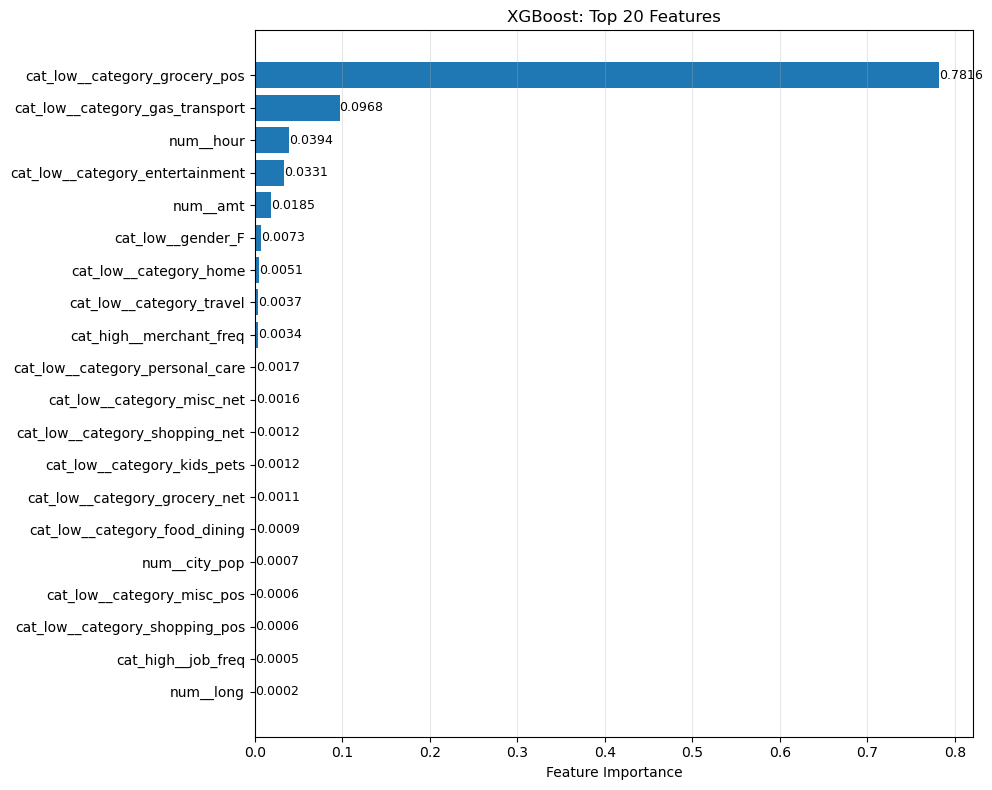

Анализ важности признаков для LightGBM:


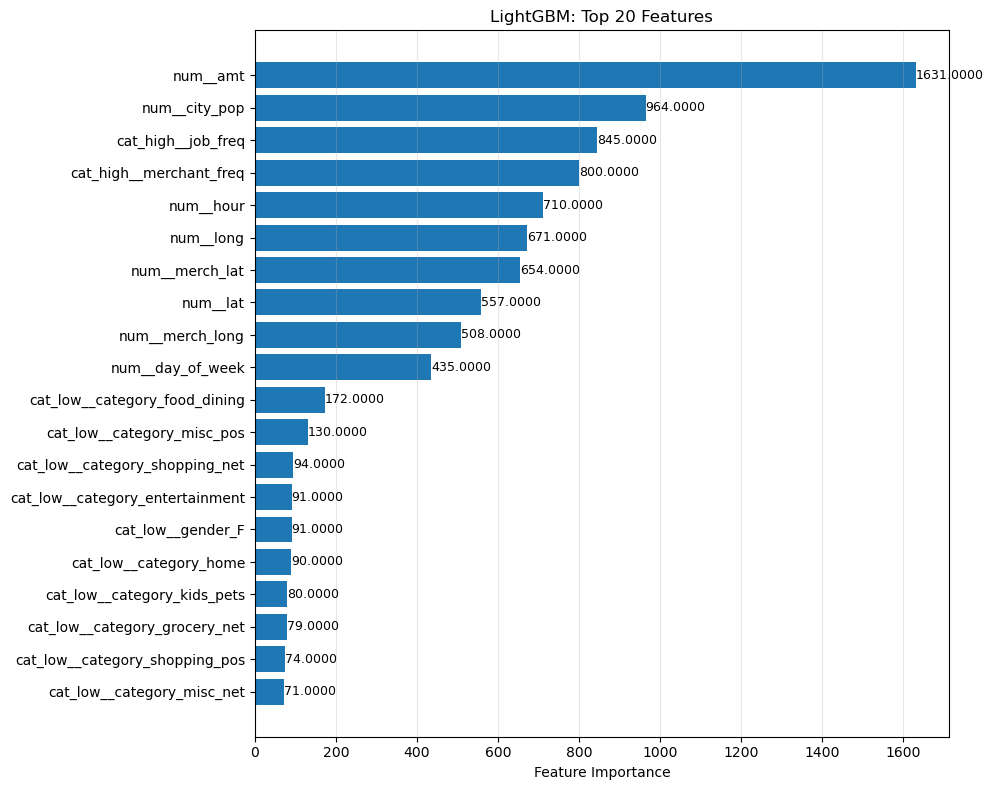

In [61]:
if 'xgb' in globals() and hasattr(xgb, 'feature_importances_'):
    print("Анализ важности признаков для XGBoost:")
    plot_feature_importance(
        xgb,
        feature_names=feature_names,
        top_n=20,
        title='XGBoost: Top 20 Features'
    )

if 'lgbm' in globals() and hasattr(lgbm, 'feature_importances_'):
    print("Анализ важности признаков для LightGBM:")
    plot_feature_importance(
        lgbm,
        feature_names=feature_names,
        top_n=20,
        title='LightGBM: Top 20 Features'
    )


LightGBM лучше выделил признаки, который действительно могут влиять на обнаружение нетипичной транзакции. XGBoost в свою очередь, очень сильно выделяет пару из категорий магазинов, в связи с этим и наблюдаем худшие метрики качества

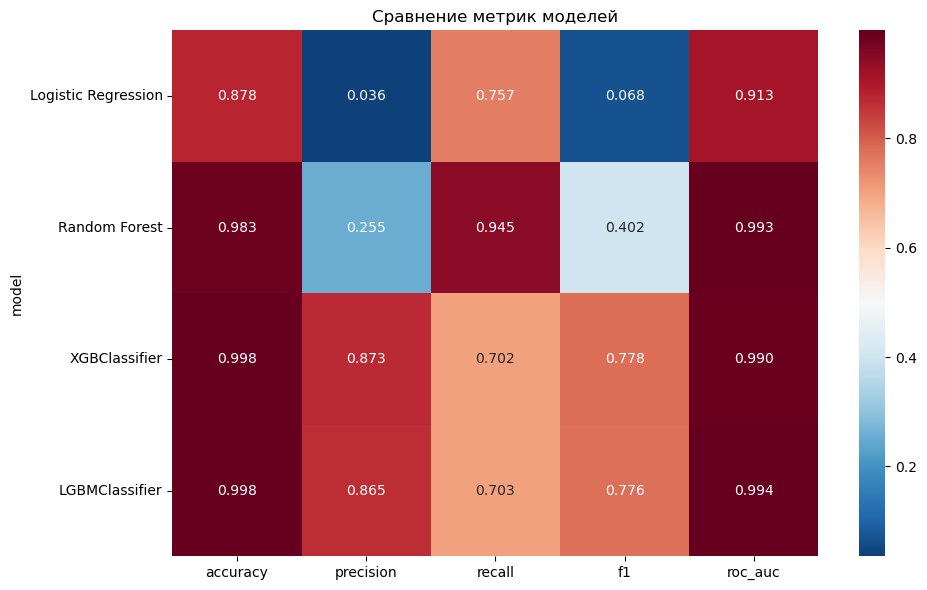

In [62]:
from eval_utils import compare_models_metrics
metrics_df = compare_models_metrics(metrics_list)